# Hoja de trabajo 2

El objetivo es seguir el tutorial de datacamp que se presenta en el artículo [Recurrent Neural Network Tutorial (RNN)](https://www.datacamp.com/tutorial/tutorial-for-recurrent-neural-network?irclickid=38yXsvxDXxyPUmn1yAVdyyL2UkF3bQV52yXfQA0&irgwc=1&utm_medium=affiliate&utm_source=impact&utm_campaign=000000_1-2003851_2-mix_3-all_4-na_5-na_6-na_7-mp_8-affl-ip_9-na_10-bau_11-Bing%20Rebates%20by%20Microsoft&utm_content=BANNER&utm_term=EdgeBingFlow). Debe incluir todo el código que se presenta. Todo el código debe funcionar. Adicional se le presentan algunas preguntas que debe responder según su criterio. 

Al GES debe cargar este mismo archivo con el tutorial corriendo correctamente y su respuesta a las preguntas planteadas.

### Código DataCamp

In [27]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)



### ¿Cuál es el objetivo o la utilidad de los siguientes módulos?

**mean_squared_error**
Función de pérdida que se utiliza en problemas de regresión cuyo objetivo principal es medir la diferencia entre las predicciones de un modelo y sus datos reales.

**Dense**
Es una capa conectada en la RNN cuyo objetivo es realizar operaciones lineales y no lineales en los datos de entrada. Ayuda a aprender relaciones complejas entre las características de entrada y las etiquetas de salida.

**LSTM**
Es un tipo avanzado de RNN el cual fue diseñado para preveer decaimiento y gradiente que explota. Ésta posee módulos que reptiten pero con estructura diferente la cual posee cuatro capas que interactúan y se comunican entre sí. Este tipo de RNN sirven para sintetización y reconocimiento de voz al igual que el reconocimiento de escritura.

**Dropout**
Se utiliza para regularizar una red neuronal al reducir el sobreajuste.

**GRU**
Derivado a que utiliza una compuerta de actualización y otra de reinicio o reset, estas puertas pueden realizar el análisis del problema del gradiente que desaparece. Éstas compuertas deciden cuál información es importante y trasladarla a la salida. La mayor diferencia radica que la arquitectura GRU tiene un menor tiempo de entrenamiento comparado con los modelos LSTM.

**Bidirectional**
Se utiliza para procesar una secuencia en ambas direcciones. Ayuda a capturar información contextual de manera más efectiva en problemas de procesamiento de secuencias.

In [28]:
dataset = pd.read_csv(
    "Mastercard_stock_history.csv", index_col="Date", parse_dates=["Date"]
).drop(["Dividends", "Stock Splits"], axis=1)
print(dataset.head())


                Open      High       Low     Close     Volume
Date                                                         
2006-05-25  3.748967  4.283869  3.739664  4.279217  395343000
2006-05-26  4.307126  4.348058  4.103398  4.179680  103044000
2006-05-30  4.183400  4.184330  3.986184  4.093164   49898000
2006-05-31  4.125723  4.219679  4.125723  4.180608   30002000
2006-06-01  4.179678  4.474572  4.176887  4.419686   62344000


In [29]:
print(dataset.describe())
# Se extraen las características de un análisis descriptivo general del dataset de los valores de apertura, alto, bajo, cierre y volumen. De estos se puede determinar cómo estuvo el comportamiento de los datos. Las columnas tienen un comportamiento similar. Pero, tomando en cuenta los límites tanto superior como inferior, se puede notar una desviación y varianza muy alta con respecto a la media de los valores.


              Open         High          Low        Close        Volume
count  3872.000000  3872.000000  3872.000000  3872.000000  3.872000e+03
mean    104.896814   105.956054   103.769349   104.882714  1.232250e+07
std     106.245511   107.303589   105.050064   106.168693  1.759665e+07
min       3.748967     4.102467     3.739664     4.083861  6.411000e+05
25%      22.347203    22.637997    22.034458    22.300391  3.529475e+06
50%      70.810079    71.375896    70.224002    70.856083  5.891750e+06
75%     147.688448   148.645373   146.822013   147.688438  1.319775e+07
max     392.653890   400.521479   389.747812   394.685730  3.953430e+08


In [30]:
# explique en sus propias palabras a que se refiere "data/Mastercard_stock_history.csv" dentro del código anterior.

In [31]:
dataset.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

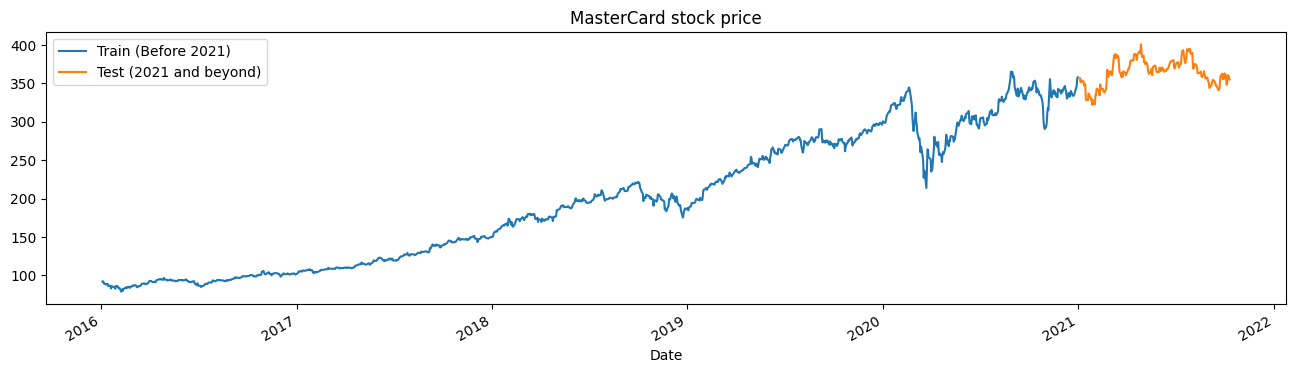

In [32]:
tstart = 2016
tend = 2020

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("MasterCard stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)





In [33]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)


Considere la función train_test_plot como un todo (no línea por línea) y explique lo siguiente
* **Que recibe?**
La función definida recibe un dataset a analizar. Adicional, se le incluyen los años o valores del intervalo a donde se debe realizar la separación de los datos train-test (2016-2020).
* **Que hace?**
La función selecciona la columna de análisis 'High' y crea un subset con el intervalo suministrado como tstart y tend como valores mínimo y máximo. Adicionalmente, para la variable test realiza la selección del año tend+1. 
* **Que devuelve?**
Y devuelve los datasets train y test.

In [34]:
# Código
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [35]:
# Código
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [36]:
# Código
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

Considere la función split_sequence como un todo (no línea por línea) y explique lo siguiente
* **Que recibe?**
Recibe el dataset ya escalado por la función MinMaxScaler y también recibe el parámetro de secuencia o step donde le indica la cantidad de valores para la agrupación a realizar.

* **Que hace?**
Crea o inicializa dos variables ***X*** y ***y***. Utiliza un ciclo for y calcula los datos de la variable end_lx donde si ésta es mayor que el largo de la secuencia menos 1, el ciclo se rompe. Adicional, crea dos variables: seq_x y seq_y. Éstas variables son anexadas a las listas ***X*** y ***y***. Posteriormente se transforman en Arrays.

* **Que devuelve?**
La función devuelve arrays de los valores agrupados ***X*** y ***y***.

In [37]:
# Código
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [38]:
# Código

# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 125)               63500     
                                                                 
 dense_3 (Dense)             (None, 1)                 126       
                                                                 
Total params: 63626 (248.54 KB)
Trainable params: 63626 (248.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Cuál es la arquitectura del modelo que se va usar?**

Se estaría utilizando la arquitectura de LSTM con 125 unidades, función de activación tanh, con optimizador 'RMSprop' y la función de pérdida MSE.

In [39]:
# Código
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
38/38 [==============================] - 3s 35ms/step - loss: 0.0111
Epoch 2/50
38/38 [==============================] - 2s 41ms/step - loss: 0.0021
Epoch 3/50
38/38 [==============================] - 2s 64ms/step - loss: 0.0023
Epoch 4/50
38/38 [==============================] - 6s 169ms/step - loss: 0.0019
Epoch 5/50
38/38 [==============================] - 7s 182ms/step - loss: 0.0014
Epoch 6/50
38/38 [==============================] - 6s 159ms/step - loss: 0.0015
Epoch 7/50
38/38 [==============================] - 6s 152ms/step - loss: 9.5288e-04
Epoch 8/50
38/38 [==============================] - 6s 146ms/step - loss: 0.0013
Epoch 9/50
38/38 [==============================] - 6s 146ms/step - loss: 9.9493e-04
Epoch 10/50
38/38 [==============================] - 5s 132ms/step - loss: 0.0010
Epoch 11/50
38/38 [==============================] - 5s 133ms/step - loss: 7.3248e-04
Epoch 12/50
38/38 [==============================] - 4s 114ms/step - loss: 9.3779e-04
Epoch 13/50


In [40]:
# Código
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)



7/7 [==============================] - 2s 32ms/step


In [41]:
# Código
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))




Considere la función return_rmse como un todo (no línea por línea) y explique lo siguiente
* **Que recibe?**
Recibe el resultado de la función mean_squared_error de los valores de los datasets test y predicted donde se les aplica la raiz cuadrada para obtener el RMSE.

* **Que hace?**
Se le aplica la raíz cuadrada para obtener el RMSE y validar la desviación que tienen los datos predichos con los reales.

* **Que devuelve?**
Devuelve el el RMSE de los datasets y sí validar el ajuste que se tiene entre los datos predichos y reales.

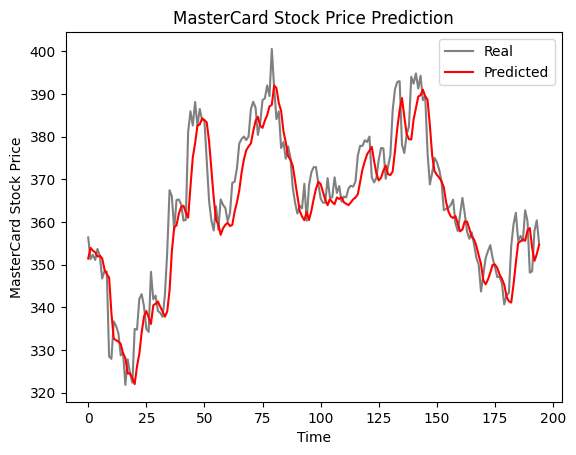

In [42]:
# Código
plot_predictions(test_set,predicted_stock_price)



In [43]:
# Código
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 6.61.


**Según el gráfico y el RMSE, considera aceptable el modelo?**\
**Si hoy es la fecha límite para el proyecto y este ha sido su mejor modelo, lo pondría en producción? Explique**\

El modelo presentado ofrece resultados similares a los reales. Adicional, tanto para el modelo LSTM como para el GRU se tienen valores bajos (6.61 y 5.88 respectivamente). Derivado de esto, se puede decir que el modelo GRU se puede usar en producción ya que ofreció menor valor de RMSE.

In [44]:
# Código
# Código
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the RNN
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 125)               48000     
                                                                 
 dense_4 (Dense)             (None, 1)                 126       
                                                                 
Total params: 48126 (187.99 KB)
Trainable params: 48126 (187.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Cuál es la arquitectura del modelo que se va usar?**\
Derivado que el modelo que presentó menor RMSE es el GRU con 5.88, se estaría utilizando este modelo.

In [45]:
# Código
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
38/38 [==============================] - 8s 136ms/step - loss: 0.0161
Epoch 2/50
38/38 [==============================] - 5s 142ms/step - loss: 0.0015
Epoch 3/50
38/38 [==============================] - 6s 164ms/step - loss: 0.0015
Epoch 4/50
38/38 [==============================] - 6s 159ms/step - loss: 0.0013
Epoch 5/50
38/38 [==============================] - 6s 152ms/step - loss: 9.7333e-04
Epoch 6/50
38/38 [==============================] - 6s 148ms/step - loss: 0.0011
Epoch 7/50
38/38 [==============================] - 8s 205ms/step - loss: 6.8731e-04
Epoch 8/50
38/38 [==============================] - 7s 176ms/step - loss: 8.8300e-04
Epoch 9/50
38/38 [==============================] - 6s 167ms/step - loss: 7.3931e-04
Epoch 10/50
38/38 [==============================] - 7s 173ms/step - loss: 8.1939e-04
Epoch 11/50
38/38 [==============================] - 7s 179ms/step - loss: 6.8276e-04
Epoch 12/50
38/38 [==============================] - 7s 175ms/step - loss: 6.4172e-

7/7 [==============================] - 1s 39ms/step


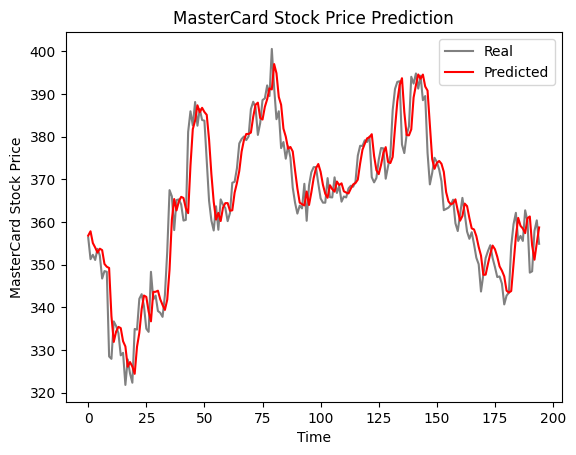

In [46]:
# Código
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [47]:
# Código
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 5.88.


**Según el gráfico y el RMSE, considera aceptable el modelo?**\
**Si hoy es la fecha límite para el proyecto y este ha sido su mejor modelo, lo pondría en producción? Explique**\

El modelo presentado ofrece resultados similares a los reales. Adicional, tanto para el modelo LSTM como para el GRU se tienen valores bajos (6.61 y 5.88 respectivamente). Derivado de esto, se puede decir que el modelo GRU se puede usar en producción ya que ofreció menor valor de RMSE.